### Vehicle Detection Project

The goals / steps of this project are the following:

   * Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
   * Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
   * Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
   * Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
   * Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
    Estimate a bounding box for vehicles detected.


### Module initializations

In [26]:
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

import math
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import cv2
import glob
import time



%matplotlib inline




### Hog Featrue Detection


 Since we want to extract the relevant features from the images in order to be able to detect vehicles, we want to first apply techniques on the orignal image so that the extracting process will perform better.. Because the HOG technique works very well in these scenarios, it was decided to apply it to the images.

Said that, the key point here was not to decide if apply HOG or not but how to apply it instead, or in other words to select a set of proper values.

It is also important to mention that the parameters not only have an effect in terms of detection but also in terms of performance. It is not the same to select 9 orientations and 8 hog cells per block. I used 2 cells per block and spatial binning dimensions of 16x16. I experimented on the isolated channels of YCrCb for increasing the speed and it was satisfying after getting the test accuracy of trainning process.



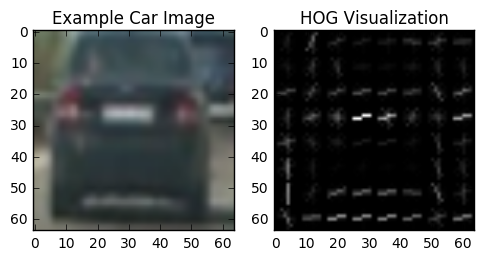

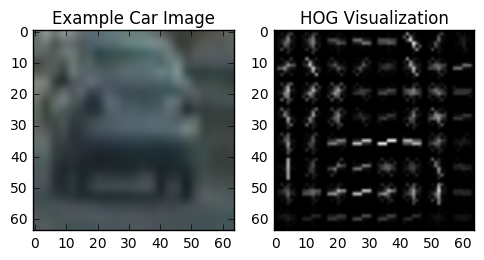

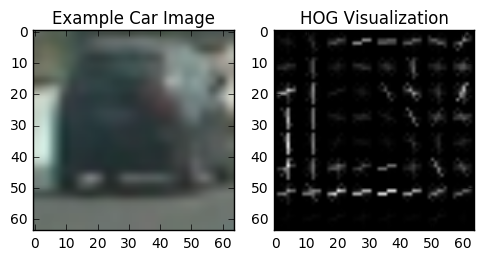

In [24]:
# Global variable for images data

image_data= [
    mpimg.imread('vehicles/GTI_MiddleClose/image0001.png'),
    mpimg.imread('vehicles/GTI_Far/image0030.png'),
    mpimg.imread('vehicles/GTI_Left/image0028.png'),

]



# parameters for Hog features,binned color features extraction
ORIENT = 9  # HOG orientations
PIX_PER_CELL = 8 # HOG pixels per cell
CELL_PER_BLOCK = 2 # HOG cells per block
SPATIAL_SIZE = (16, 16)# Spatial binning dimensions
HIST_BINS = 16 

# Read in cars and notcars
cars = glob.glob('vehicles/**/*.png', recursive=True)
not_cars = glob.glob('non-vehicles/**/*.png', recursive=True)


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    return hog(img, orientations=orient, 
                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                  cells_per_block=(cell_per_block, cell_per_block), 
                  transform_sqrt=True, 
                  visualise=vis, feature_vector=feature_vec)




# Plot the examples
for image in image_data:
    # Call our function with vis=True to see an image output
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(gray, ORIENT, 
                        PIX_PER_CELL, CELL_PER_BLOCK, 
                        vis=True, feature_vec=False)

    fig = plt.figure(figsize = (15,15))
    plt.subplot(5,5,1)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(5,5,2)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')


### Binned & color features

Below are the helper function that I used for spatial bins and color histograms with the HOG features,

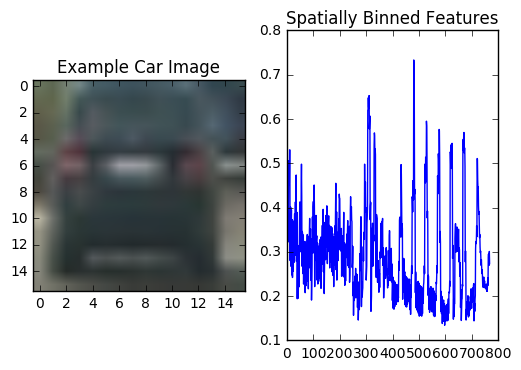

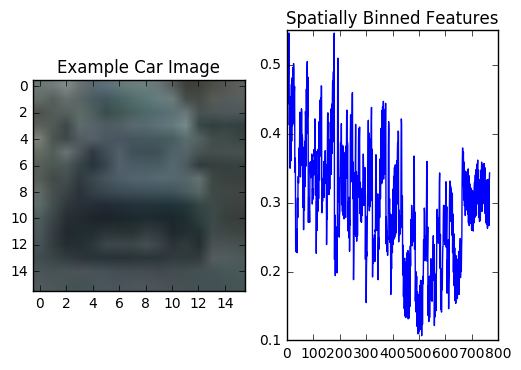

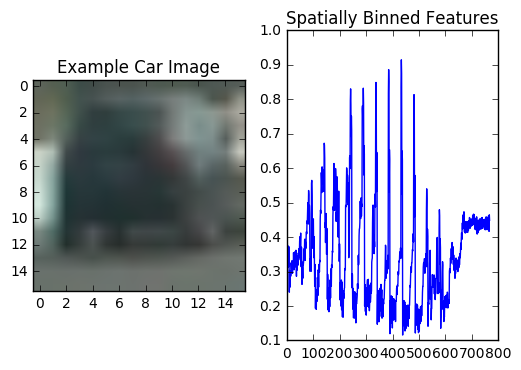

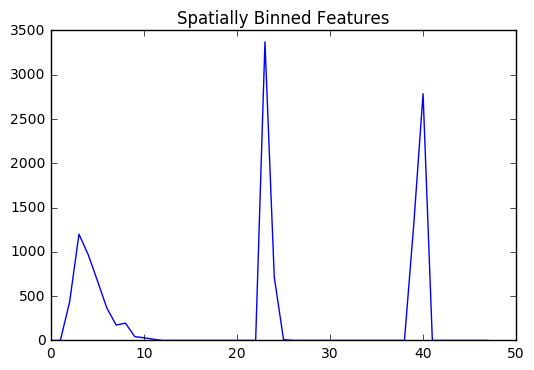

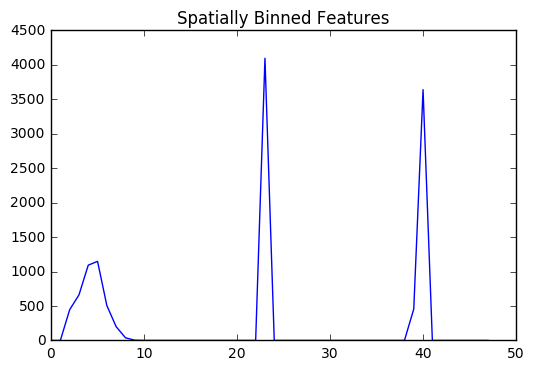

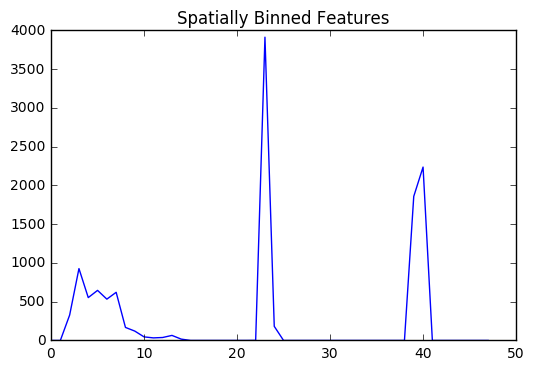

In [25]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


for image in image_data:
    vector = bin_spatial(image, SPATIAL_SIZE)

    # Plot features
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(cv2.resize(image, SPATIAL_SIZE))
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.plot(vector)
    plt.title('Spatially Binned Features')

    
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

   # Number of histogram bins

for image in image_data:
    feature_vec = color_hist(cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb), HIST_BINS)
    
    # Plot features
    plt.figure()
    plt.plot(feature_vec)
    plt.title('Spatially Binned Features')

### Extract features & Classifier training
 * The first step after visualizing the data set and extracting feature is to extract features from the datasset. I then make sure that the vehicle and nonvehicle features are stacked together and scaled. I defined two cases for extracting features which consists of one for single image extraction and the other for combining the extraction.


 * I trained the support vector machine with the given dataset so that the machine itself is able to classify car and non-car examples. Prior to training, the data is split into training sets and the labels are stacked. Most  portion of the time is spent on training the SVC and the test accuracy was great since it was above 90% overall.

In [11]:
#  Adapted Udacity's solution of extracting single image features
# Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        features.append(single_img_features(image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat))
        features.append(single_img_features(np.fliplr(image), color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat))
    # Return list of feature vectors
    return features





# Global variables
# Flag declarations
color_space = 'YCrCb' 
hog_channel = 1
spatial_feat = True 
hist_feat = True 
hog_feat = True 

print("Extracting car features")
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                        orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                        cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract...')
print("Extracting non_car features")
t=time.time()
notcar_features = extract_features(not_cars, color_space=color_space, 
                        spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                        orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                        cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract...')


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',ORIENT,'orientations',PIX_PER_CELL,
    'pixels per cell and', CELL_PER_BLOCK,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Extracting car features
88.48 Seconds to extract...
Extracting non_car features
100.43 Seconds to extract...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
365.71 Seconds to train SVC...
Test Accuracy of SVC =  0.9704
My SVC predicts:  [ 1.  1.  1.  1.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  0.  0.  1.  0.  0.]
0.10824 Seconds to predict 10 labels with SVC


### Find Cars

 Udacity 's solution on finding cars. I didt not use this method but it might leads to better result

In [ ]:


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    image_boxes=[]
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
  

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                image_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] +=1
    return draw_img,heatmap

### Search Window
The solution above was based on 32 by 32 images of vehicles and not-vehicles.In order to fit the current input in our model it was crucial to apply a sliding window search along the images to extract pieces from them and convert them in something that the model can processes.Since we know the general location of the car in the image, we can therefore scan that portion of the image. It was necessary to apply a sliding window search technique, where basically the image is divided into N pieces, and each one is separately processed. For filtering false positives, I used heatmaps to highlight the detected regions with a helper function. Only a portion of the image will be processed by the filter, so false positive areas are less likely to detected.  

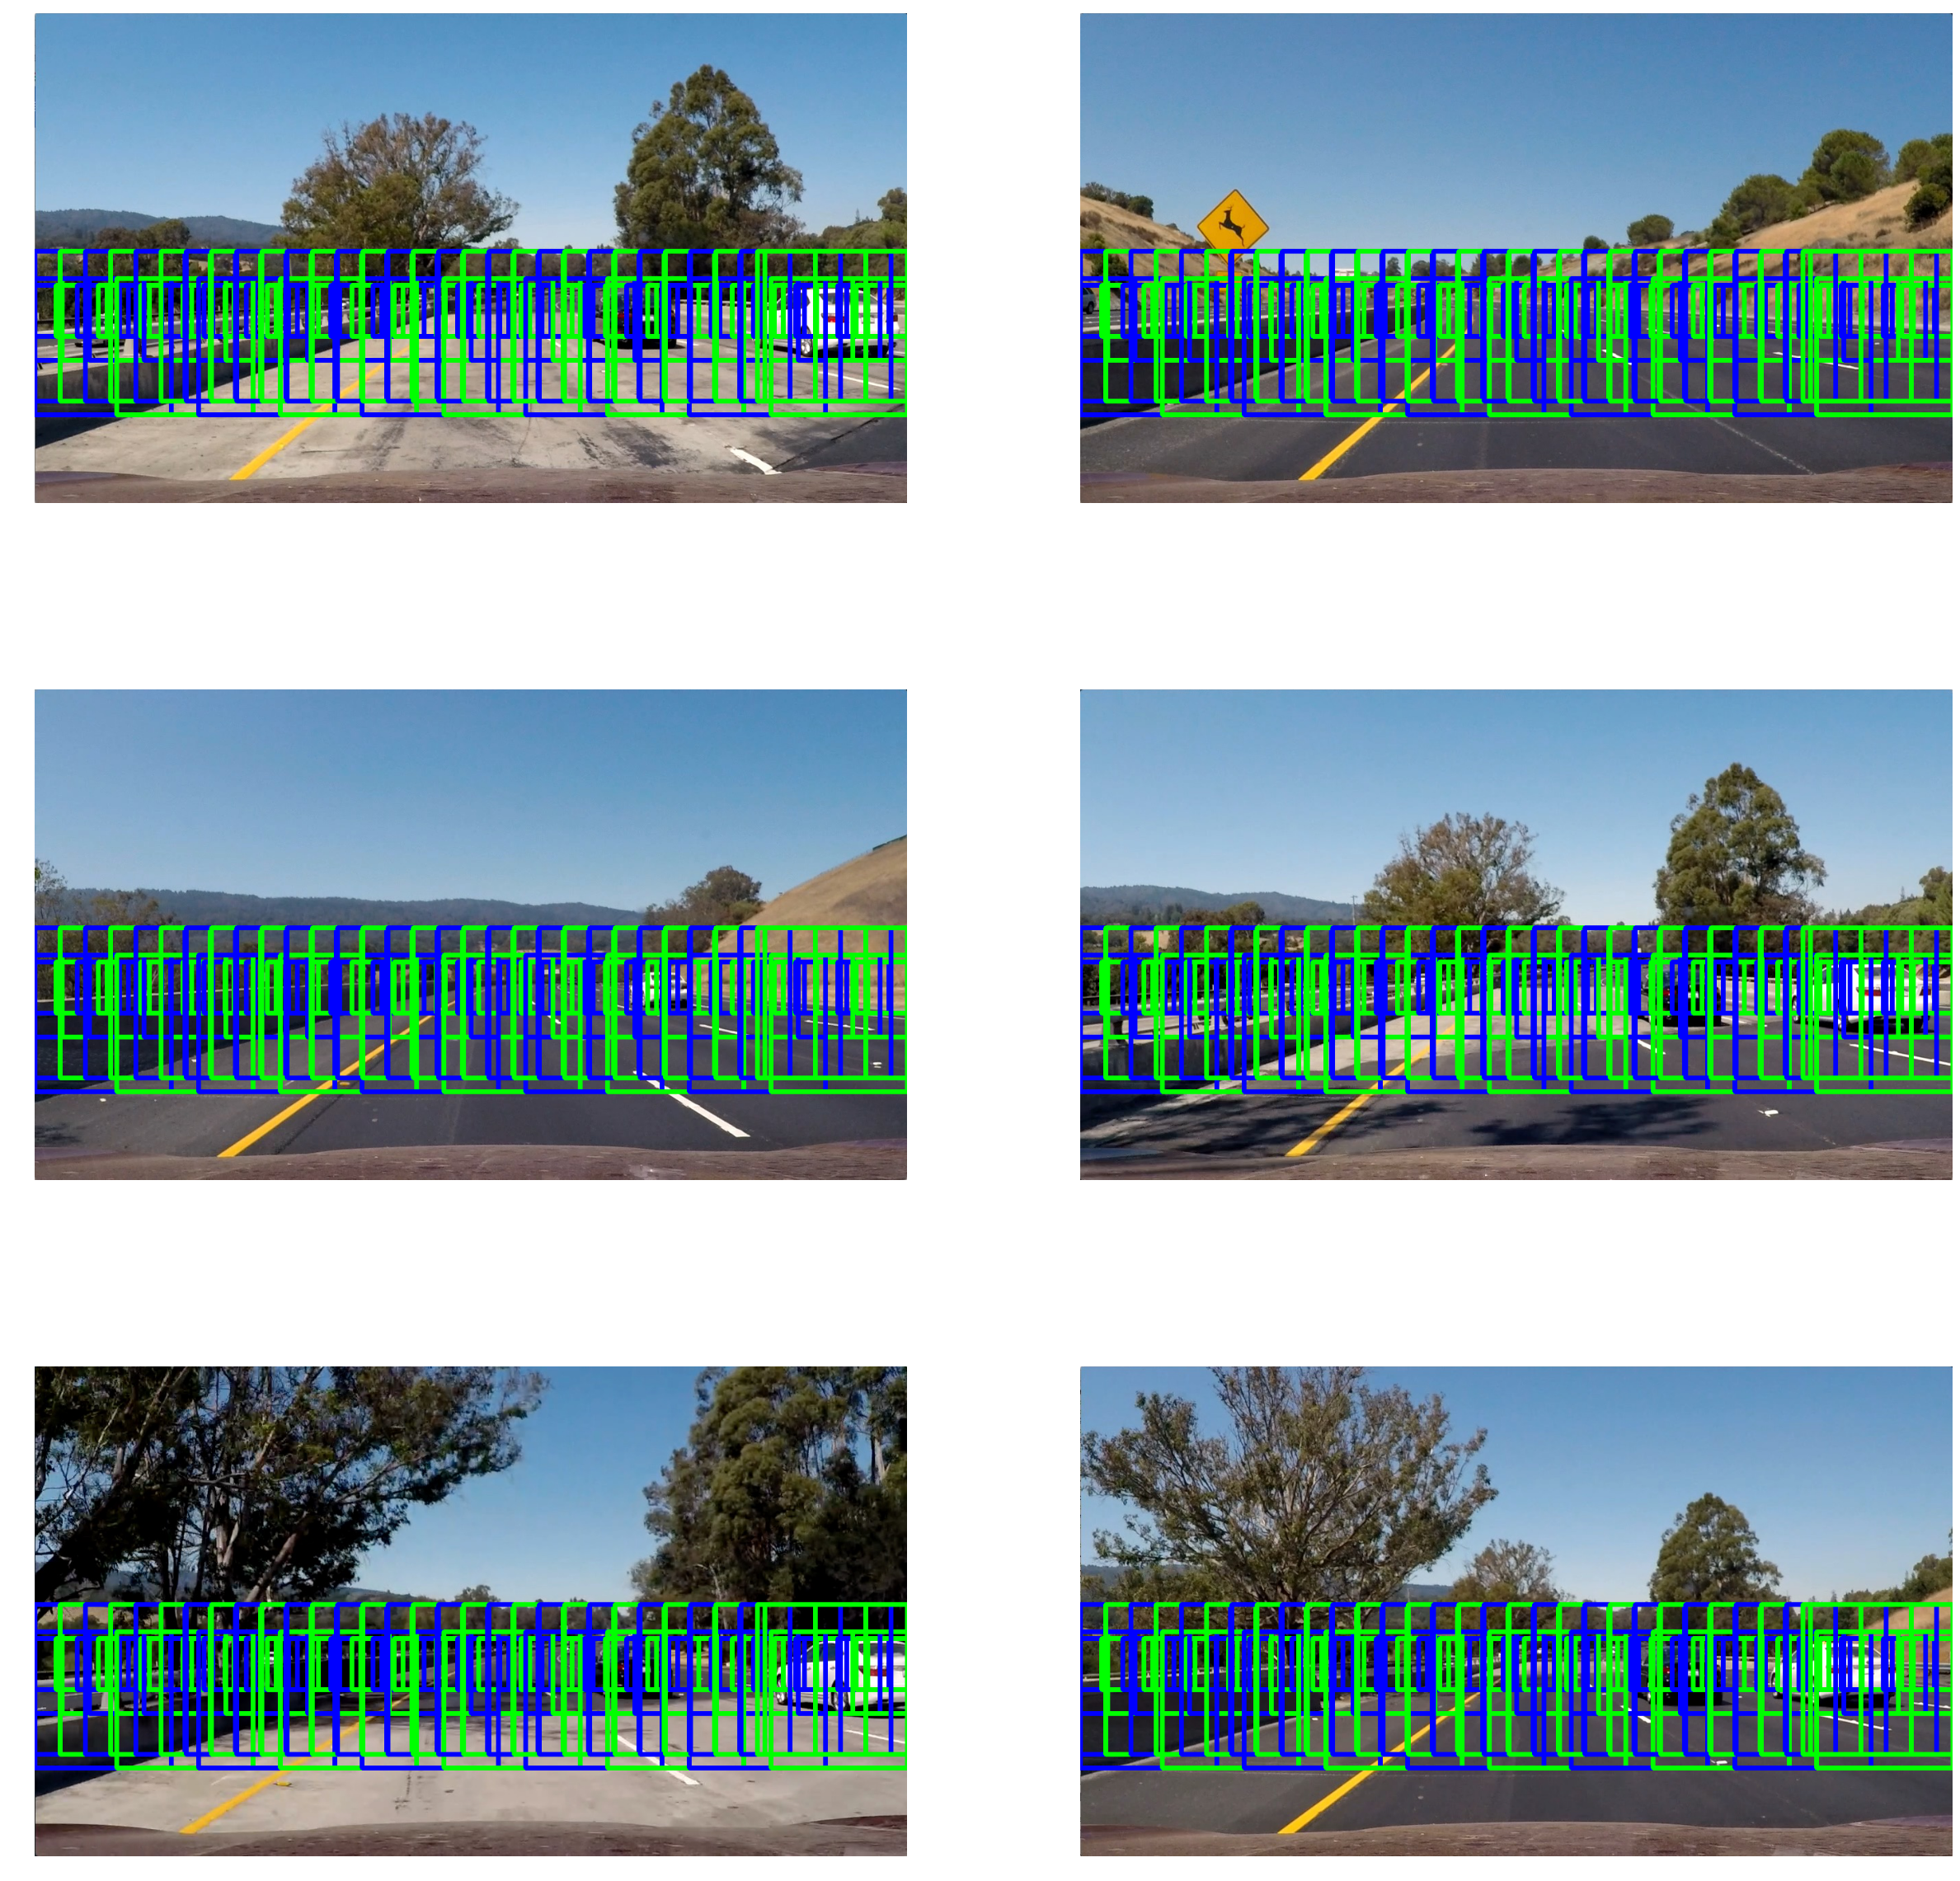

In [12]:
def stride_windows(img, win_size, num_win_x, y_top):
    x_right = img.shape[1] - win_size
    x_stride = int(round(x_right / (num_win_x-1)))
    windows = []
    for xs in range(num_win_x-1):
        windows.append(((xs*x_stride, y_top), (xs*x_stride+win_size, y_top+win_size)))
    # Make sure that the last window is pushed all the way to the edge
    windows.append(((x_right, y_top),(img.shape[1], y_top+win_size)))
    return windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    colors = [(0, 0, 255), (0, 255, 0)]
    for idx, bbox in enumerate(bboxes):
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], colors[idx%2], thick)
    # Return the image copy with boxes drawn
    return imcopy

def form_windows(image):
    windows = []
    coords = [
        (75, 40, 400),
        (120, 30, 390),
        (200, 10, 390),
        (220, 30, 350),
    ]
    for win_size, num_win_x, y_top in coords:
        windows.extend(stride_windows(image, win_size, num_win_x, y_top))
    return windows

images = glob.glob('test_images/test*.jpg')
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(30,30))
index = 0
for ax in axs:
    for x in ax:
        image = mpimg.imread(images[index])
        windows = form_windows(image)
        window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6) 
        # Convert to uint8 so that imshow displays properly
        x.imshow(window_img.astype(np.uint8))
        x.axis('off')
        index += 1
plt.show()

### Filter for false positives and Methods for Combining overlapping bounding boxes

After creating the heatmap, the heatmap will be thresholded by using the apply_threshold method. I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.





In [20]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Here is my implementation of the pipline and the output of six frames and their corresponding heatmaps

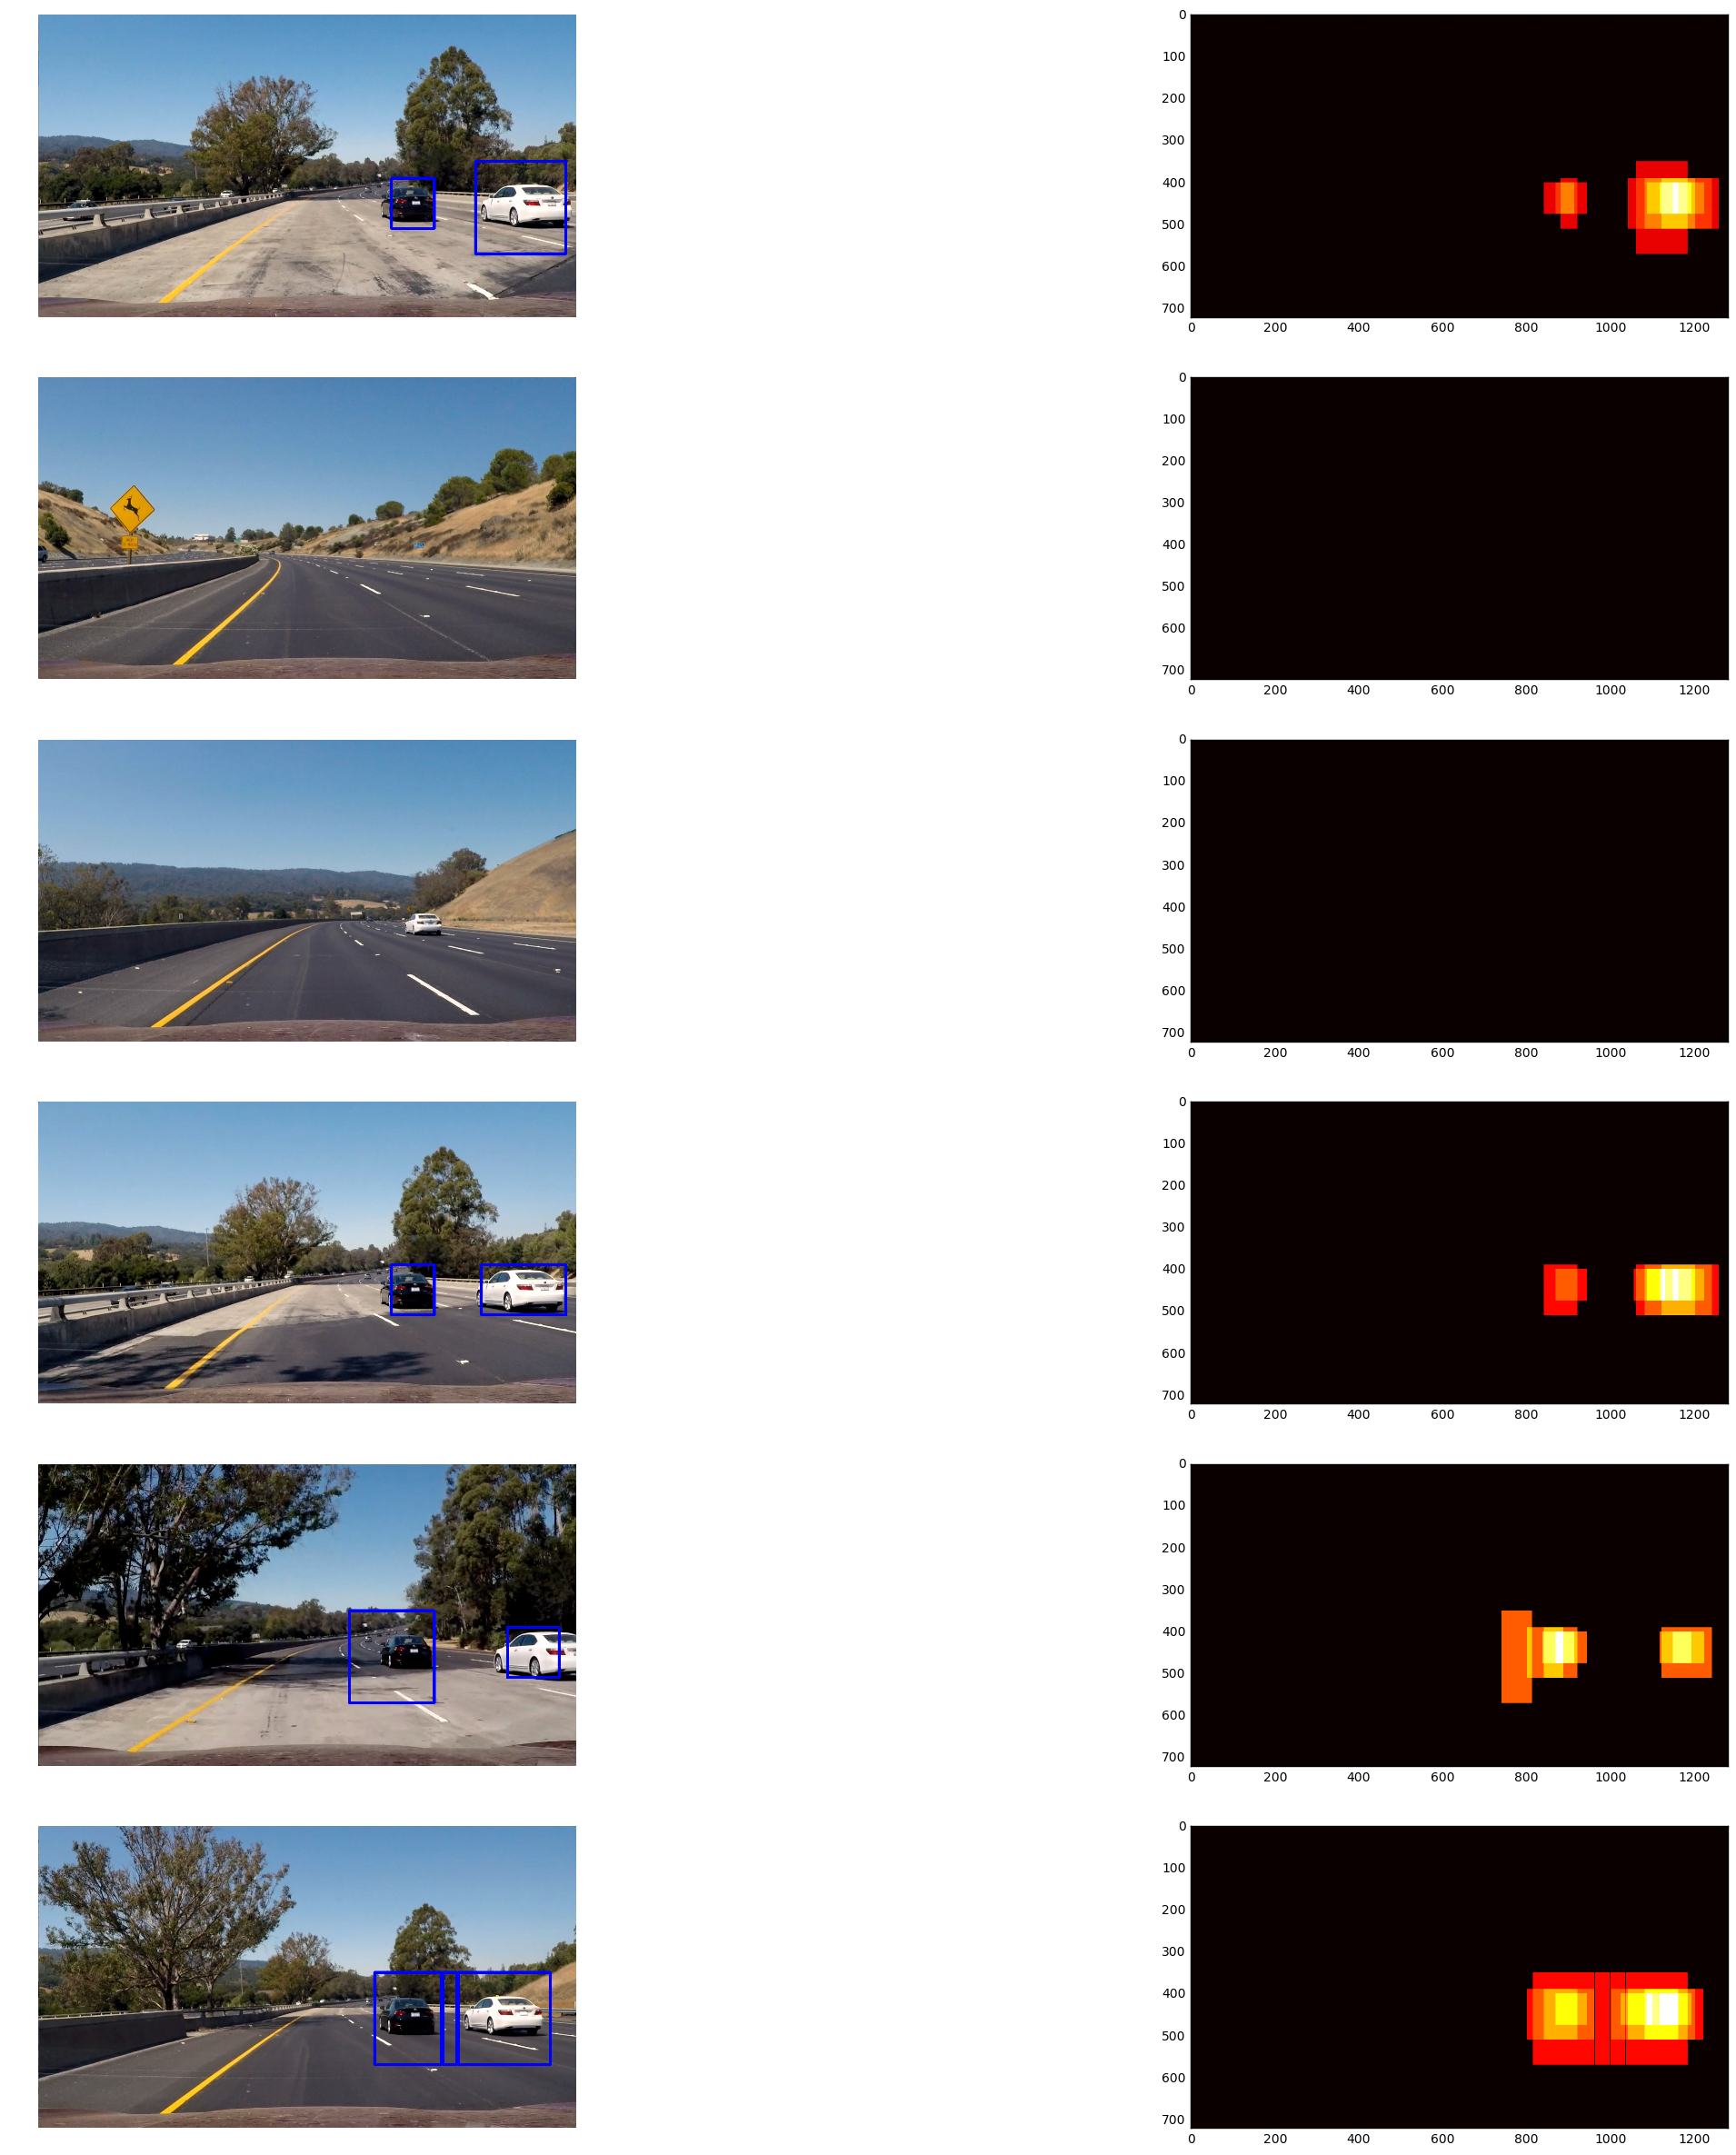

In [21]:
def pipeline(image, return_heatmap=False):
 
    image = image.astype(np.float32)/255

    formed_windows = form_windows(image)

    heat_window = search_windows(image, formed_windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                            orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                            cell_per_block=CELL_PER_BLOCK, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    # Initialize and add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,heat_window)

    # Apply threshold to help remove false positives
    heat_thresholded = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_thresholded, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(np.copy(image)*255, labels)
    if return_heatmap:
        return draw_image, heatmap
    return draw_image

figure, axis = plt.subplots(len(images), 2, figsize=(30,30))
index = 0
for index, axis in enumerate(axs):
    img = mpimg.imread(images[index])
    image_drawn, heatmap = pipeline(img, True)
    # Convert to uint8 so that imshow displays properly
    axis[0].imshow(image_drawn.astype(np.uint8))
    axis[0].axis('off')
    axis[1].imshow(heatmap, cmap='hot')
plt.show()

### Video Processing

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def nothing(img):
    return img
white_output = './fitted.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./fitted.mp4
[MoviePy] Writing video ./fitted.mp4


100%|█████████▉| 1260/1261 [08:00<00:00,  2.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./fitted.mp4 

CPU times: user 6min 11s, sys: 32.5 s, total: 6min 44s
Wall time: 8min 2s


### Discussion
 The selection of paramters for feature extraction is really important for the outcome of this project and I tried several attempts by doing intuitive experimentation. I got lots of bad results,but eventually I was abel to overcome it.
 Udacity provided several great helper functions that I used and I was being seletive at the moment so that there are some techniques that I didn't manage to use. The pipeline is the main core of this project, but this pipeline sometimes does not produce perfect result due to its limitations on generate false positives.
 Again, Although the test accuracy is really high, the bounding box sometimes becomes unstable and therefore interepret objects that look like vehicles as objects. This can definitely be improved by using a more optimized algorithm to distinguish the difference between vehicles and vechile-likes. By using the SVMs on this project, the program is able to detect cars from the opposite direction and I think the overall result is good compared to the approach of using deep learning knowledge.